# Survival Analysis

In this notebook, I will be using the Cox proportional hazards model to illustrate the difference in sex and marital status on longevity. The data comes from the U.S. National Health Interview Survey which records the birth year and death year of over a million individuals. Death records stop in 2009 (when the dataset was considered complete), so any people who are still living in 2009 will need to be right-censored. Some people do not have date of birth. Those cases will be truncated.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf

First, load and preview the data.

In [2]:
data = pd.read_csv("nhis.csv")
print(data.head())
print(data.shape)

   Unnamed: 0  YEAR           NHISPID  AGE  SEX  SEXORIEN  MARSTAT  BIRTHYR  \
0     2744230  1986  1986109602890101   60    1       NaN       11      NaN   
1     2744231  1986  1986109602890102   54    2       NaN       11      NaN   
2     2744232  1986  1986109602890103   21    1       NaN       50      NaN   
3     2744233  1986  1986109602890201   46    1       NaN       11      NaN   
4     2744234  1986  1986109602890202   38    2       NaN       11      NaN   

   MORTSTAT  MORTDODY  
0       1.0    2005.0  
1       1.0    2010.0  
2       2.0    9999.0  
3       2.0    9999.0  
4       2.0    9999.0  
(1605246, 10)


In [3]:
print(data.YEAR.value_counts())

1988    86844
1987    86646
1992    85273
1990    85099
1991    84826
1989    83105
1994    81481
1993    77415
1995    70971
1997    67986
2000    64502
2001    64000
1998    63308
2009    62401
1999    62327
2005    61929
2004    60072
2002    59269
2003    57245
2006    50970
2008    50934
2007    50901
1996    43899
1986    43843
Name: YEAR, dtype: int64


Now, clean the data.

In [4]:
# Drop cases where birth year is not known
data2 =data[(data["BIRTHYR"]<=2009) & (data["BIRTHYR"].notnull())]

# Add new feature for time-to-event
data2["Longevity"]= data2["MORTDODY"] - data2["BIRTHYR"]

# Create a 'status' variable where 1 means dead and 0 means alive as of 2009
data2["dead"]=2-data2['MORTSTAT']

# For people who were alive as of 2009, calculate their longevity as their age in 2009
data2.loc[data2['dead']==0,"Longevity"] = 2009 -data2.loc[data2['dead']==0,"BIRTHYR"] 

# Create a binary variable where 1 = female and 0 = male
data2["female"] = (data2["SEX"] == 2).astype(int)

print(data2.head())
print(data2.shape)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


        Unnamed: 0  YEAR         NHISPID  AGE  SEX  SEXORIEN  MARSTAT  \
829402     3928174  1997  19970003080101   33    2       NaN       11   
829403     3928175  1997  19970003080102   36    1       NaN       11   
829404     3928178  1997  19970003090101   42    1       NaN       11   
829405     3928179  1997  19970003090102   52    2       NaN       11   
829407     3928182  1997  19970003100101   41    1       NaN       11   

        BIRTHYR  MORTSTAT  MORTDODY  Longevity  dead  female  
829402   1963.0       2.0    9999.0       46.0   0.0       1  
829403   1960.0       2.0    9999.0       49.0   0.0       0  
829404   1954.0       1.0    1999.0       45.0   1.0       0  
829405   1944.0       2.0    9999.0       65.0   0.0       1  
829407   1955.0       2.0    9999.0       54.0   0.0       0  
(754219, 13)


/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


After cleaning, we have gone from 1,605,246 records to 1,305,561.

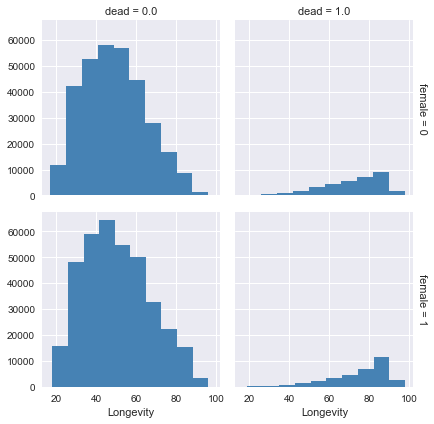

In [5]:
g = sns.FacetGrid(data2, row="female", col="dead",margin_titles=True)
g.map(plt.hist, "Longevity", color="steelblue", lw=0)
plt.show()

The graphs that correspond to dead = 1.0 have much less data than the graphs for dead = 0.0, which shows us that the vast majority of our sample was still living as of 2009. This means most of our data will be right-censored.

Now we're going to use the statsmodels survival analysis functions to create some models for our data. First, we can calculate the Hazard (risk of death) for each age, starting at the youngest people in the sample (18 years old in 2009).

In [6]:
sf = sm.SurvfuncRight(data2["Longevity"], data2["dead"])
sf.summary().head()

/anaconda/lib/python3.6/site-packages/statsmodels/duration/survfunc.py:55: RuntimeWarning: divide by zero encountered in log
  sp = np.log(sp)
/anaconda/lib/python3.6/site-packages/statsmodels/duration/survfunc.py:65: RuntimeWarning: divide by zero encountered in true_divide
  se = d / (n * (n - d)).astype(np.float64)
/anaconda/lib/python3.6/site-packages/statsmodels/duration/survfunc.py:68: RuntimeWarning: invalid value encountered in multiply
  se *= sp


,Surv prob,Surv prob SE,num at risk,num events
Time,,,,
18.0,0.999997,0.000002,754217,2.0
19.0,0.999981,0.000005,753439,12.0
20.0,0.999940,0.000009,751911,31.0
21.0,0.999879,0.000013,749414,46.0
22.0,0.999825,0.000015,746169,40.0


What can we observe from this survival table so far?
- First, only 2 people in the sample died at the age of 18, with the number of deaths increasing after that.
- Second, the standard error steadily gets larger as the sample size (the number at risk/number of people still alive at that timepoint) shrinks.
- Finally, the 'number at risk' drops at each timepoint, but by quite a bit more than the number of deaths. This reflects our right-censoring. If someone turned 18 in 2009 and didn't die, they don't count toward the 'number at risk' at age 19 because they're out of the observation window, but they also aren't an event at timepoint 18 because they were still alive at that age.

Let's make a survival plot for the men and the women:

/anaconda/lib/python3.6/site-packages/statsmodels/duration/survfunc.py:55: RuntimeWarning: divide by zero encountered in log
  sp = np.log(sp)
/anaconda/lib/python3.6/site-packages/statsmodels/duration/survfunc.py:65: RuntimeWarning: divide by zero encountered in true_divide
  se = d / (n * (n - d)).astype(np.float64)
/anaconda/lib/python3.6/site-packages/statsmodels/duration/survfunc.py:68: RuntimeWarning: invalid value encountered in multiply
  se *= sp


(0.85, 1)

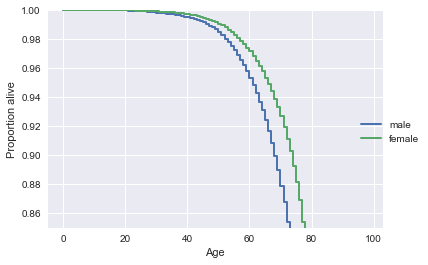

In [7]:
# Code for this plot modified from the statsmodels documentation at http://www.statsmodels.org/dev/duration.html

groups = data2.groupby("female")
ax = plt.axes()
sexes = ["male","female"]

# Fitting a survival function for each group
for group in groups:
    sf = sm.SurvfuncRight(group[1]["Longevity"], group[1]["dead"])
    sf.plot(ax)
    
li = ax.get_lines()
plt.figlegend((li[0], li[2]), sexes, "center right")
ax.set_ylabel("Proportion alive")
ax.set_xlabel("Age")
ax.set_autoscaley_on(False)
ax.set_ylim([.85,1])

Most people are still alive, but this may be due to extreme right-censoring. To find a statistical difference in longevity for men and women, we can test using the Cox PH model.

In [8]:
mod = smf.phreg("Longevity ~  female", # The model
                data2, # The data
                status=data2['dead'].values # Whether values are right-censored
                ) 
rslt = mod.fit()
print(rslt.summary())

                       Results: PHReg
Model:                  PH Reg        Sample size:     754217
Dependent variable:     Longevity     Num. events:     67383 
Ties:                   Breslow                              
-------------------------------------------------------------
        log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
-------------------------------------------------------------
female -0.4460    0.0078 0.6402 -57.5296 0.0000 0.6306 0.6500
Confidence intervals are for the hazard ratios


Judging by the Hazard Ratio (HR) of the Cox PH model, we can say that at any given age, women are 64% less likely to die than men (with a 95% confidence interval of 63% to 65%). This difference is statistically significant at α of .05 (p < .0001). The large size of our sample is contributing to the small confidence interval. <br>

The plot above indicates that the survival discrepancy between male/female shrinks a bit after age 80, which is an observation that cannot be seen in the Cox PH model. This suggests that either we should include some additional features in the model to try and account for this discrepancy, or use a different modeling technique that doesn't assume that the effects of features are consistent across all values. <br>

Let's plot the predicted survival rates from the model:

        Unnamed: 0  YEAR         NHISPID  AGE  SEX  SEXORIEN  MARSTAT  \
829402     3928174  1997  19970003080101   33    2       NaN       11   
829403     3928175  1997  19970003080102   36    1       NaN       11   
829404     3928178  1997  19970003090101   42    1       NaN       11   
829405     3928179  1997  19970003090102   52    2       NaN       11   
829407     3928182  1997  19970003100101   41    1       NaN       11   

        BIRTHYR  MORTSTAT  MORTDODY  Longevity  dead  female  predicted  
829402   1963.0       2.0    9999.0       46.0   0.0       1   0.994803  
829403   1960.0       2.0    9999.0       49.0   0.0       0   0.988401  
829404   1954.0       1.0    1999.0       45.0   1.0       0   0.992777  
829405   1944.0       2.0    9999.0       65.0   0.0       1   0.956459  
829407   1955.0       2.0    9999.0       54.0   0.0       0   0.978739  


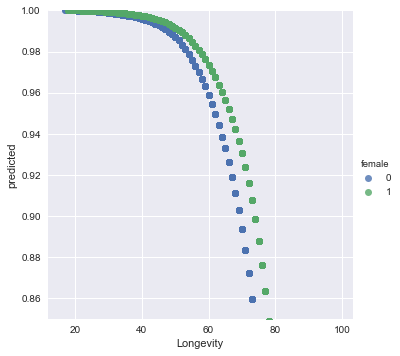

In [9]:
data3=data2[(data2['Longevity'].notnull()) & (data2['female'].notnull()) & (data2['dead'].notnull())]
data3["predicted"] = rslt.predict(pred_type='surv').predicted_values

print(data3.head())

sns.lmplot(x="Longevity", y="predicted", hue="female", data=data3,fit_reg=False,lowess=True)
plt.ylim(.85, 1)
plt.show()

Compared to the survival rates from the raw data, it does appear this model is missing some elements, including the shrinkage in the gender difference after 80, but also the leveling-off of the survival rate once people get to 90 years or older. Again, adding more parameters may help. <br>

They say that people who get married live longer than people who don't. Let's add marital status as a feature and recalculate the survival plot and the hazard ratio for being married at any point in a lifetime. <br>

First, let's take a look at the values that comprise the raw marital status feature.

In [10]:
print(data2.MARSTAT.value_counts())

11    251130
10    180579
50    170198
30     74561
20     49623
40     19796
12      5602
99      2722
13         8
Name: MARSTAT, dtype: int64


There are many label types, the meaning of which can be seen below:

- 00: NIU
- 10: Married
- 11: Married - Spouse present
- 12: Married - Spouse not in household
- 13: Married - Spouse in household unknown
- 20: Widowed
- 30: Divorced
- 40: Separated
- 50: Never married
- 99: Unknown marital status

We will make a boolean variable 'married' that encodes 1 if the respondent has definitively been married, 0 if they have never been married, and drops all other values.

In [11]:
data4 = data2[(data2.MARSTAT != 00) & (data2.MARSTAT != 99)]

# Create a 'married' variable where 1 means has been married and 0 means never married as of 2009
data4['married'] = data4['MARSTAT'].apply(lambda x: 0 if x == 50 else 1)
print(data4.head())

print(len(data4[data4.married == 0]))
print(len(data4[data4.married == 1]))

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


        Unnamed: 0  YEAR         NHISPID  AGE  SEX  SEXORIEN  MARSTAT  \
829402     3928174  1997  19970003080101   33    2       NaN       11   
829403     3928175  1997  19970003080102   36    1       NaN       11   
829404     3928178  1997  19970003090101   42    1       NaN       11   
829405     3928179  1997  19970003090102   52    2       NaN       11   
829407     3928182  1997  19970003100101   41    1       NaN       11   

        BIRTHYR  MORTSTAT  MORTDODY  Longevity  dead  female  married  
829402   1963.0       2.0    9999.0       46.0   0.0       1        1  
829403   1960.0       2.0    9999.0       49.0   0.0       0        1  
829404   1954.0       1.0    1999.0       45.0   1.0       0        1  
829405   1944.0       2.0    9999.0       65.0   0.0       1        1  
829407   1955.0       2.0    9999.0       54.0   0.0       0        1  
170198
581299


We have 170,198 respondents who have never been married and 581,299 who have reported being married at some point in their life. Let's visualize these two groups and how they differ in longevity.

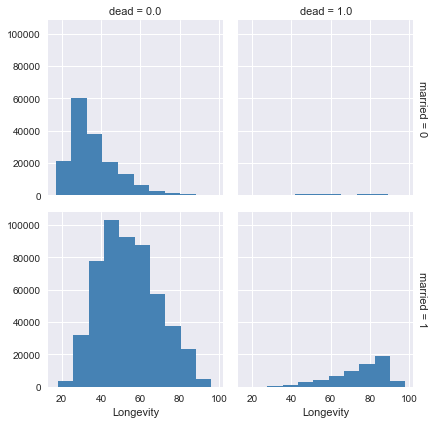

In [14]:
g = sns.FacetGrid(data4, row="married", col="dead",margin_titles=True)
g.map(plt.hist, "Longevity", color="steelblue", lw=0)
plt.show()

There is hardly any data for the never been married group that died in the study period. This is probably because people who report never having been married are typically younger. For the respondents who are still alive, we can see that the age distribution is shifted to the left, with fewer datapoints. There may not be enough reliable data to draw a valid conclusion.

Still, let's calculate the Hazard (risk of death) for each age.

In [15]:
sf = sm.SurvfuncRight(data4["Longevity"], data4["dead"])
sf.summary().head()

/anaconda/lib/python3.6/site-packages/statsmodels/duration/survfunc.py:55: RuntimeWarning: divide by zero encountered in log
  sp = np.log(sp)
/anaconda/lib/python3.6/site-packages/statsmodels/duration/survfunc.py:65: RuntimeWarning: divide by zero encountered in true_divide
  se = d / (n * (n - d)).astype(np.float64)
/anaconda/lib/python3.6/site-packages/statsmodels/duration/survfunc.py:68: RuntimeWarning: invalid value encountered in multiply
  se *= sp


,Surv prob,Surv prob SE,num at risk,num events
Time,,,,
18.0,0.999997,0.000002,751495,2.0
19.0,0.999981,0.000005,750717,12.0
20.0,0.999940,0.000009,749189,31.0
21.0,0.999878,0.000013,746692,46.0
22.0,0.999825,0.000015,743450,40.0


The number of people at risk at every age is smaller compared to the male/female data because there are fewer datapoints.

/anaconda/lib/python3.6/site-packages/statsmodels/duration/survfunc.py:55: RuntimeWarning: divide by zero encountered in log
  sp = np.log(sp)
/anaconda/lib/python3.6/site-packages/statsmodels/duration/survfunc.py:65: RuntimeWarning: divide by zero encountered in true_divide
  se = d / (n * (n - d)).astype(np.float64)
/anaconda/lib/python3.6/site-packages/statsmodels/duration/survfunc.py:68: RuntimeWarning: invalid value encountered in multiply
  se *= sp


(0.85, 1)

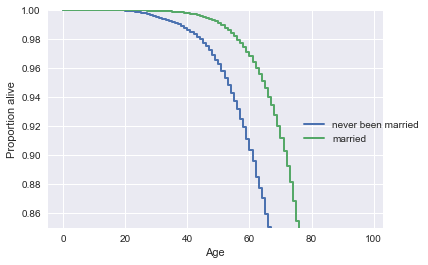

In [19]:
groups = data4.groupby("married")
ax = plt.axes()
marital_status = ["never been married", "married"]

# Fitting a survival function for each group
for group in groups:
    sf = sm.SurvfuncRight(group[1]["Longevity"], group[1]["dead"])
    sf.plot(ax)
    
li = ax.get_lines()
plt.figlegend((li[0], li[2]), marital_status, "center right")
ax.set_ylabel("Proportion alive")
ax.set_xlabel("Age")
ax.set_autoscaley_on(False)
ax.set_ylim([.85,1])

As the hypothesis suggests, the population of respondents that have been married drop off later than those who have never been married. However, it is important to note that the population of single respondents is smaller in comparison, which may be skewing the results. Let's test using the Cox PH model.

In [20]:
mod = smf.phreg("Longevity ~  married", # The model
                data4, # The data
                status=data4['dead'].values # Whether values are right-censored
                ) 
rslt = mod.fit()
print(rslt.summary())

                        Results: PHReg
Model:                   PH Reg        Sample size:     751495
Dependent variable:      Longevity     Num. events:     67184 
Ties:                    Breslow                              
--------------------------------------------------------------
         log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
--------------------------------------------------------------
married -0.6716    0.0140 0.5109 -47.9976 0.0000 0.4971 0.5251
Confidence intervals are for the hazard ratios


The Cox PH model indicates that at any given age, married respondents are 51% less likely to die than respondents who have never been married. We observe a 95% confidence interval of 50% to 53%. This difference is statistically significant at α of .05 (p < .0001). <br>

Now, let's plot the prediction.

        Unnamed: 0  YEAR         NHISPID  AGE  SEX  SEXORIEN  MARSTAT  \
829402     3928174  1997  19970003080101   33    2       NaN       11   
829403     3928175  1997  19970003080102   36    1       NaN       11   
829404     3928178  1997  19970003090101   42    1       NaN       11   
829405     3928179  1997  19970003090102   52    2       NaN       11   
829407     3928182  1997  19970003100101   41    1       NaN       11   

        BIRTHYR  MORTSTAT  MORTDODY  Longevity  dead  female  married  \
829402   1963.0       2.0    9999.0       46.0   0.0       1        1   
829403   1960.0       2.0    9999.0       49.0   0.0       0        1   
829404   1954.0       1.0    1999.0       45.0   1.0       0        1   
829405   1944.0       2.0    9999.0       65.0   0.0       1        1   
829407   1955.0       2.0    9999.0       54.0   0.0       0        1   

        predicted  
829402   0.994110  
829403   0.991479  
829404   0.994769  
829405   0.948548  
829407   0.984121  


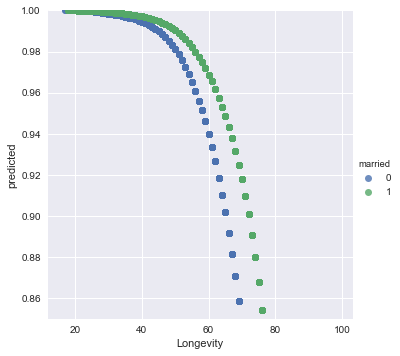

In [21]:
data5=data4[(data4['Longevity'].notnull()) & (data4['married'].notnull()) & (data4['dead'].notnull())]
data5["predicted"] = rslt.predict(pred_type='surv').predicted_values

print(data5.head())

sns.lmplot(x="Longevity", y="predicted", hue="married", data=data5,fit_reg=False,lowess=True)
plt.ylim(.85, 1)
plt.show()

Our prediction matches the raw data, with married respondents living longer than single respondents. But how does this finding fit into the male/female paradigm? Let's add marital status and gender into the Cox PH model and see how they stack up against eachother.

In [22]:
mod = smf.phreg("Longevity ~  married + female", # The model
                data4, # The data
                status=data4['dead'].values # Whether values are right-censored
                ) 
rslt = mod.fit()
print(rslt.summary())

                        Results: PHReg
Model:                   PH Reg        Sample size:     751495
Dependent variable:      Longevity     Num. events:     67184 
Ties:                    Breslow                              
--------------------------------------------------------------
         log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
--------------------------------------------------------------
married -0.6774    0.0140 0.5079 -48.3792 0.0000 0.4942 0.5221
female  -0.4466    0.0078 0.6398 -57.5148 0.0000 0.6302 0.6496
Confidence intervals are for the hazard ratios


        Unnamed: 0  YEAR         NHISPID  AGE  SEX  SEXORIEN  MARSTAT  \
829402     3928174  1997  19970003080101   33    2       NaN       11   
829403     3928175  1997  19970003080102   36    1       NaN       11   
829404     3928178  1997  19970003090101   42    1       NaN       11   
829405     3928179  1997  19970003090102   52    2       NaN       11   
829407     3928182  1997  19970003100101   41    1       NaN       11   

        BIRTHYR  MORTSTAT  MORTDODY  Longevity  dead  female  married  \
829402   1963.0       2.0    9999.0       46.0   0.0       1        1   
829403   1960.0       2.0    9999.0       49.0   0.0       0        1   
829404   1954.0       1.0    1999.0       45.0   1.0       0        1   
829405   1944.0       2.0    9999.0       65.0   0.0       1        1   
829407   1955.0       2.0    9999.0       54.0   0.0       0        1   

        predicted married/female  
829402   0.995348         (1, 1)  
829403   0.989488         (1, 0)  
829404   0.993552

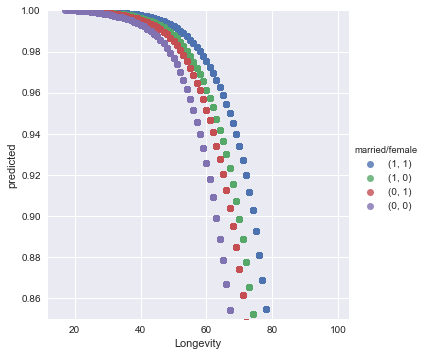

In [31]:
data5 = data4[(data4['Longevity'].notnull()) & (data4['married'].notnull()) & (data4['female'].notnull()) & (data4['dead'].notnull())]
data5["predicted"] = rslt.predict(pred_type='surv').predicted_values
data5['married/female'] = data6.apply(lambda row: (row['married'],row['female']), axis=1)
print(data5.head())

sns.lmplot(x="Longevity", y="predicted", hue="married/female", data=data5,fit_reg=False,lowess=True)
plt.ylim(.85, 1)
plt.show()

Our predictions show that female respondents who have been married survive the longest, with male married respondents next. Unmarried female respondents are close behind, while unmarried male respondents have the lowest survival rate. This indicates that getting married is a stronger indicator for survival than gender. <br>

What could be contributing to this phenomena? One thing to consider is that married couples tend to stay home more, which means they are likely eating more homecooked meals, while single people tend to go out and socialize more, likely consuming more alcohol, which has detrimental effects on the body. Another theory is that married couples may find more fulfillment, either in their partner or in their children/family unit, which may reduce stress and contribute to longevity. Yet another reason could be that married people may have more responsibilities to their family, which may influence their lifestyle decisions towards healthy choices.

Through this notebook, we have shown that American females tend to live longer than males, and that people who have been married at some point in their lifetime tend to live longer than poeple who have never been married. Using a Cox PH model indicated that at any given age, females were 64% less likely to die than men, though the raw data suggested that there were different effects in different age groups. Applying the Cox PH model with the marital status indicated that at any age, married individuals were 51% less likely to die than single individuals. When considering both features in the model, it appeared that marriage was a stronger indicator than gender.